# Imports

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn import metrics, tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessio

# Data loading & Preprocessing Funcs

In [2]:
# DATA LOADING
# Find file paths on kaggle
def find_all_file_paths():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

# Load data from CSV
def load_csv(data_dir, filename):
    df = pd.read_csv(os.path.join(data_dir, filename))
    return df


In [3]:
# CLEANING FUNCS
def drop_zero_variance_features(df):
    nunique = df.nunique() # num of unique values in each col
    drop_cols = nunique[nunique==1].keys().values
    for drop_col in drop_cols:
        df.drop([drop_col], axis=1, inplace=True)
        
    return df

def check_null_values(df):
    null_sum= df.isnull().sum()
    if null_sum.values.sum()!=0:
        print('WARNING!! THE FOLLOWING FEATURES CONTAIN NULL VALUES:')
        print(null_sum[null_num!=0].keys())
    else:
        print('No null values in existing dataframe.')
        
def check_dup_values(df):
    if df.duplicated().sum()==0:
        print('No duplicated rows in existing dataframe.')
    else:
        print('WARNING!! THE FOLLOWING ROWS CONTAIN DUPLICATES:')
        print(df[df.duplicated()])

        
        

    
    

In [4]:
# PREPROCESSING

def label_encoder(df, feature_list):
    '''
    Feature list: list of features that you want to encode from categorical data
    '''
    le = LabelEncoder()
    for i in feature_list:
        df[i] = le.fit_transform(df[i])
    return df

def one_hot_encoder(df,feature_list):

    ohe = OneHotEncoder(
        categories='auto',  # Categories per feature
        drop=None, # Whether to drop one of the features
        sparse=True, # Will return sparse matrix if set True
        dtype=np.float64, # Desired data type of the output
        handle_unknown='error' # Whether to raise an error 
    )   
    for i in feature_list:
        transformed = ohe.fit_transform(df[[i]])
        df[ohe.categories_[0]] = transformed.toarray()
        df.drop([i],axis=1,inplace=True)
    return df

def split_feature_target(df,target): 
    X = df.drop(target,axis =1)
    y = df[target]
    return X,y

def normalize_features(X):
    sc = StandardScaler()
    X = sc.fit_transform(X)
#     assert(np.mean(X, axis=0)[np.random.randint(X.shape[1])]==0)
#     assert(np.std(X, axis=0)[np.random.randint(X.shape[1])]==1)
   
    return X
    

In [5]:
def balanced_sampler(X,y, random_state=42):

    over = SMOTE(random_state=random_state)
    under = RandomUnderSampler()

    steps = [('o', over),('u', under)]
    imbpipeline = imbpipe(steps)

    X, y = imbpipeline.fit_resample(X, y)

    print(f'resampled y: {pd.Series(y).value_counts()}')
    return X,y

def initialize_model(model_name,params={}): 
    # Initialize model
    if model_name=='SVM':
        model = SVC(**params) 
    elif model_name=='DecisionTree':
        model = tree.DecisionTreeClassifier(**params)
    elif model_name=='LogisticRegression':
        model = LogisticRegression()
        model = RFE(model,**params)
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(**params)
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier(**params)
    elif model_name == 'KNeighbors':
        model = KNeighborsClassifier(**params)
    elif model_name == 'NaiveBayes':
        model = GaussianNB(**params)

    return model

def test_metrics(model,X_test,y_test):
    y_pred=model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test,y_pred) # correctly predicted/all labels
    precision = metrics.precision_score(y_test, y_pred) # True positive / all detected positives (sensitivity)
    recall = metrics.recall_score(y_test, y_pred)  # True positive / all actual positives (true poitive + negative false)
    classification_report = metrics.classification_report(y_test, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, classification_report, confusion_matrix, y_pred

def generate_hyperparams_dict(model_name):
    if model_name=='SVM':
        hyperparams_dict={
            'C': (np.arange(2,3,0.1)) , 
            'gamma': [0.01,0.02,0.03,0.04,0.05], 
            'kernel': ['linear', 'poly', 'rbf'],
            'degree': [2,3,4]
        }
    elif model_name =='DecisionTree':
        hyperparams_dict = {"criterion":("gini","entropy"),
               "splitter":("best","random"),
               "max_depth":list(range(1,20)),
               "min_samples_split":[2,3,4],
               "min_samples_leaf":list(range(1,20))}
    elif model_name == 'LogisticRegression':
        hyperparams_dict = {'n_features_to_select':list(range(1,26))}
    elif model_name == 'RandomForest':
        hyperparams_dict = {'n_estimators': np.linspace(100,1000, 10).astype('int')          
        }
    elif model_name == 'AdaBoost':
        hyperparams_dict = {'n_estimators': np.linspace(100,1000, 10).astype('int')          
        }
    elif model_name == 'KNeighbors':
        hyperparams_dict = {'n_neighbors': np.linspace(1,20,20).astype('int')          
        }
    elif model_name == 'NaiveBayes':
        hyperparams_dict = {'var_smoothing': np.linspace(1e-5,1e-9, 20)         
        }
    return hyperparams_dict
    


# Plotting funcs


In [6]:
def plot_correlation(df, method='spearman', show=True, cols=[], cmap='cool'):
    if show:
        if not cols:
            df=df
        else:
            df = df[cols]
        figure = plt.figure(figsize=(14,10))
        sns.heatmap(df.corr(method = method),
                    annot=True, 
                    fmt = ".1f", 
                    cmap = cmap)
        plt.show()

def plot_confusion_matrix(y_test, y_pred=None, confusion_matrix=[], classes=[0,1]):
    if not y_pred == None:
        cnf_mat = metrics.confusion_matrix(y_test, y_pred)
    else:
        cnf_mat = confusion_matrix
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_mat), annot=True, cmap="Reds" ,fmt='g')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('Real label')
#     ax.xaxis.set_label_position("top")

# Main

## Data cleaning & preprocessing
save this result and use this result later

In [7]:
# Step 1: Data loading
df = load_csv(data_dir='/kaggle/input/ibm-hr-analytics-attrition-dataset/',filename='WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Step 2: Data Cleaning
# 2.0 Select useful columns
select_cols = ['Attrition','DistanceFromHome','Education','EnvironmentSatisfaction','Gender','JobLevel','JobRole','JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','TotalWorkingYears','WorkLifeBalance','YearsInCurrentRole']
df = df[select_cols]
# 2.1: Drop zero variance features
df = drop_zero_variance_features(df)
# 2.2 Check null values
check_null_values(df)
# 2.3 Check duplicates
check_dup_values(df)

# Step 3: Data preprocessing
# 3.1 Categorical encoding: label encoding
df = label_encoder(df, feature_list=['Gender','Attrition'])
# One-hot encoding (??Do we really need this for job role??)
df = one_hot_encoder(df,feature_list=['JobRole'])    

# 3.2 Remove highly-correlated features
# Plot Correlation
plot_correlation(df, show=False, cmap='RdBu_r')
'''
'YearsInCurrentRole' strongly correlated to 'YearsAtCompany'
'JobLevel' strongly correlated to 'MonthlyIncome'
'JobLevel' strongly correlated to 'TotalWorkingYears'
'MonthlyIncome' strongly correlated to 'TotalWorkingYears'
'YearsAtCompany' strongly correlated to 'YearsWithCurrManager'
'YearsAtCompany' strongly correlated to 'YearsInCurrRole'
'YearsInCurrRole' strongly correlated to 'YearsWithCurrManager'
--> Remove 'TotalWorkingYears','YearsInCurrentRole','JobLevel', 'YearsWithCurrManager'
'''
remove_cols = ['TotalWorkingYears','YearsInCurrentRole','JobLevel']
df.drop(remove_cols, axis=1, inplace=True)
# 3.3 Normalize feature values
X,y = split_feature_target(df,target='Attrition')
X = normalize_features(X)
y= np.array(y)

# 3.4 Save CSV
df.to_csv('cleaned_data.csv')
df

No null values in existing dataframe.
No duplicated rows in existing dataframe.


,Attrition,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,WorkLifeBalance,Healthcare Representative,Human Resources,Laboratory Technician,Manager,Manufacturing Director,Research Director,Research Scientist,Sales Executive,Sales Representative
0,1,1,2,2,0,4,5993,19479,8,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,8,1,3,1,2,5130,24907,1,23,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,2,2,4,1,3,2090,2396,6,15,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,3,4,4,0,3,2909,23159,1,11,3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,2,1,1,1,2,3468,16632,9,12,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,0,23,2,3,1,4,2571,12290,4,17,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1466,0,6,1,4,1,1,9991,21457,4,15,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1467,0,4,3,2,1,2,6142,5174,1,20,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1468,0,2,3,4,1,2,5390,13243,2,14,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
all_models = ['LogisticRegression', 'SVM', 'DecisionTree', 'RandomForest', 'AdaBoost', 'KNeighbors', 'NaiveBayes']
n_folds=5
resample_all=True

results_dict={}
for model_name in all_models:
    results_dict[model_name] = {}
    results_dict[model_name] = {
        'cv_evaluation':{
            'train_accuracy':[],
            'train_precision':[],
            'train_recall':[],
            'test_accuracy':[],
            'test_precision':[],
            'test_recall':[]
        },
        'test_scores':{
            'accuracy':[],
            'precision':[],
            'recall':[],
            'classification_report':[],
            'confusion_matrix':[]
        }
}
    
if resample_all:
    X_, y_ = balanced_sampler(X,y, random_state=42)
    # Train & test split
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.2, random_state = 42)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    # Resample train set to make it balance
    X_train, y_train = balanced_sampler(X_train,y_train, random_state=42)

for model_name in all_models:
    print(f'\n---Test model {model_name}---')
    # Train model once with default params--> test metrics
    print("\n---Test model with default params---")
    model = initialize_model(model_name=model_name)
    model.fit(X_train,y_train)
    accuracy, precision, recall, classification_report, confusion_matrix, y_pred = test_metrics(model=model,X_test=X_test,y_test=y_test)
    print(f'Accuracy: {np.round(accuracy,3)}, Precision: {np.round(precision,3)}, Recall: {np.round(recall,3)}')
    print(f'Classification report: \n {classification_report}')

    # Hyperparameter search
    print("\n---Search for best hyperparams---")
    hyperparams_dict = generate_hyperparams_dict(model_name=model_name)
    model_search = GridSearchCV(estimator=model, param_grid=hyperparams_dict, cv=n_folds, scoring='accuracy', verbose=1) # DO WE USE ACCURACY HERE OR RECALL??
    model_search.fit(X_train, y_train)
    print(f'Best model score {model_search.best_score_}')
    best_params = model_search.best_params_
    print(f'Best hyperparams: {best_params}')

    # Evaluate the model with the best hyperparams using cross validatioon on training data
    print("\n---Evaluate model with best hyperparams on training set---")
    model_best = initialize_model(model_name=model_name, params=best_params)
    cv = KFold(n_splits=n_folds)
    cv_results = cross_validate(model,X_train,y_train, cv = cv, scoring = ["accuracy",'precision','recall'], return_train_score=True)
    results_dict[model_name]['cv_evaluation']['train_accuracy'], \
    results_dict[model_name]['cv_evaluation']['train_precision'], \
    results_dict[model_name]['cv_evaluation']['train_recall'], \
    results_dict[model_name]['cv_evaluation']['test_accuracy'], \
    results_dict[model_name]['cv_evaluation']['test_precision'], \
    results_dict[model_name]['cv_evaluation']['test_recall'] = cv_results['train_accuracy'],\
        cv_results['train_precision'],\
        cv_results['train_recall'],\
        cv_results['test_accuracy'],\
        cv_results['test_precision'],\
        cv_results['test_recall']
    
    # Test model with the best hyperparams
    print("\n---Test model with best hyperparams---")
    model_best = initialize_model(model_name=model_name, params=best_params)
    model_best.fit(X_train,y_train)
    accuracy, precision, recall, classification_report, confusion_matrix, y_pred = test_metrics(model=model_best,X_test=X_test,y_test=y_test)
    print(f'Accuracy: {np.round(accuracy,3)}, Precision: {np.round(precision,3)}, Recall: {np.round(recall,3)}')
    print(f'Classification report: \n {classification_report}')

    results_dict[model_name]['test_scores']['accuracy'],\
    results_dict[model_name]['test_scores']['precision'],\
    results_dict[model_name]['test_scores']['recall'],\
    results_dict[model_name]['test_scores']['classification_report'],\
    results_dict[model_name]['test_scores']['confusion_matrix'] = accuracy, precision, recall, classification_report, confusion_matrix

    print('\n')
        
    

resampled y: 0    1233
1    1233
dtype: int64

---Test model LogisticRegression---

---Test model with default params---
Accuracy: 0.686, Precision: 0.67, Recall: 0.728
Classification report: 
               precision    recall  f1-score   support

           0       0.70      0.65      0.67       248
           1       0.67      0.73      0.70       246

    accuracy                           0.69       494
   macro avg       0.69      0.69      0.69       494
weighted avg       0.69      0.69      0.69       494


---Search for best hyperparams---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    7.2s finished


Best model score 0.6871155946796891
Best hyperparams: {'n_features_to_select': 19}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.662, Precision: 0.649, Recall: 0.699
Classification report: 
               precision    recall  f1-score   support

           0       0.68      0.62      0.65       248
           1       0.65      0.70      0.67       246

    accuracy                           0.66       494
   macro avg       0.66      0.66      0.66       494
weighted avg       0.66      0.66      0.66       494




---Test model SVM---

---Test model with default params---
Accuracy: 0.798, Precision: 0.772, Recall: 0.841
Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.75      0.79       248
           1       0.77      0.84      0.81       246

    accuracy                           0.80       494
   macro avg       0.80      0.80      0.80       494
weighted

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed:  4.1min finished


Best model score 0.8351898734177216
Best hyperparams: {'C': 2.7000000000000006, 'degree': 4, 'gamma': 0.05, 'kernel': 'poly'}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.862, Precision: 0.813, Recall: 0.939
Classification report: 
               precision    recall  f1-score   support

           0       0.93      0.79      0.85       248
           1       0.81      0.94      0.87       246

    accuracy                           0.86       494
   macro avg       0.87      0.86      0.86       494
weighted avg       0.87      0.86      0.86       494




---Test model DecisionTree---

---Test model with default params---
Accuracy: 0.818, Precision: 0.807, Recall: 0.833
Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       248
           1       0.81      0.83      0.82       246

    accuracy                           0.82       494
   macro a

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 21660 out of 21660 | elapsed:  2.4min finished


Best model score 0.8229981366060528
Best hyperparams: {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.858, Precision: 0.852, Recall: 0.866
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.86       248
           1       0.85      0.87      0.86       246

    accuracy                           0.86       494
   macro avg       0.86      0.86      0.86       494
weighted avg       0.86      0.86      0.86       494




---Test model RandomForest---

---Test model with default params---
Accuracy: 0.919, Precision: 0.929, Recall: 0.907
Classification report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       248
           1       0.93      0.91      0.92       246

    accuracy                

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


Best model score 0.9117483775621666
Best hyperparams: {'n_estimators': 300}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.921, Precision: 0.922, Recall: 0.919
Classification report: 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       248
           1       0.92      0.92      0.92       246

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494




---Test model AdaBoost---

---Test model with default params---
Accuracy: 0.86, Precision: 0.861, Recall: 0.858
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       248
           1       0.86      0.86      0.86       246

    accuracy                           0.86       494
   macro avg       0.86      0.86      0.86       494
weighted av

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.4min finished


Best model score 0.8818312664653345
Best hyperparams: {'n_estimators': 700}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.897, Precision: 0.911, Recall: 0.878
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       248
           1       0.91      0.88      0.89       246

    accuracy                           0.90       494
   macro avg       0.90      0.90      0.90       494
weighted avg       0.90      0.90      0.90       494




---Test model KNeighbors---

---Test model with default params---
Accuracy: 0.808, Precision: 0.728, Recall: 0.98
Classification report: 
               precision    recall  f1-score   support

           0       0.97      0.64      0.77       248
           1       0.73      0.98      0.84       246

    accuracy                           0.81       494
   macro avg       0.85      0.81      0.80       494
weighted 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished


Best model score 0.8727032063226885
Best hyperparams: {'n_neighbors': 2}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.877, Precision: 0.827, Recall: 0.951
Classification report: 
               precision    recall  f1-score   support

           0       0.94      0.80      0.87       248
           1       0.83      0.95      0.88       246

    accuracy                           0.88       494
   macro avg       0.88      0.88      0.88       494
weighted avg       0.89      0.88      0.88       494




---Test model NaiveBayes---

---Test model with default params---
Accuracy: 0.632, Precision: 0.584, Recall: 0.902
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.36      0.50       248
           1       0.58      0.90      0.71       246

    accuracy                           0.63       494
   macro avg       0.69      0.63      0.60       494
weighted av

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


Best model score 0.6247317355265694
Best hyperparams: {'var_smoothing': 1e-05}

---Evaluate model with best hyperparams on training set---

---Test model with best hyperparams---
Accuracy: 0.632, Precision: 0.584, Recall: 0.902
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.36      0.50       248
           1       0.58      0.90      0.71       246

    accuracy                           0.63       494
   macro avg       0.69      0.63      0.60       494
weighted avg       0.69      0.63      0.60       494





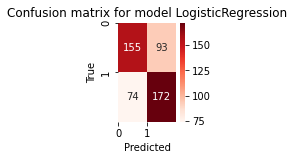

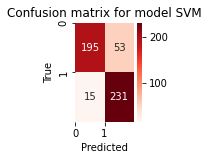

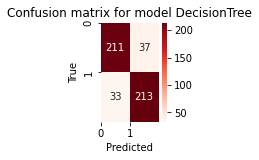

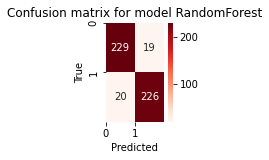

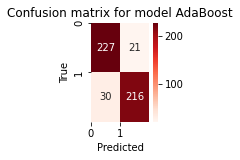

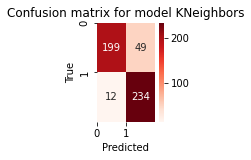

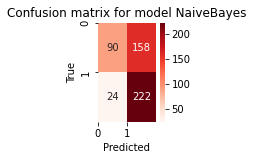

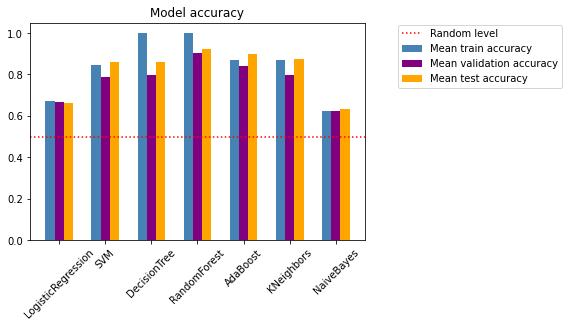

In [9]:
# Plotting

# Plot all confusion matrices
plot_rows = 2
plot_cols = len(all_models)//plot_rows + int(bool(len(all_models)%plot_rows))
i = 1
plt.figure()
for model_name in all_models:
    plt.subplot(plot_rows, plot_cols, i)
    plot_confusion_matrix(y_test, confusion_matrix=results_dict[model_name]['test_scores']['confusion_matrix'], classes=[0,1])
    plt.title('Confusion matrix for model '+model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    i+=1
    
    
# Plot all train/val/test accuracies
plt.figure()
x = np.arange(len(all_models))
width = 0.2

all_model_train_acc = []
all_model_val_acc = []
all_model_test_acc = []
for model_name in all_models:
    all_model_train_acc.append(np.mean(results_dict[model_name]['cv_evaluation']['train_accuracy']))
    all_model_val_acc.append(np.mean(results_dict[model_name]['cv_evaluation']['test_accuracy']))
    all_model_test_acc.append(results_dict[model_name]['test_scores']['accuracy'])
# plot data in grouped manner of bar type
plt.bar(x-0.2, all_model_train_acc, width, label='Mean train accuracy', color='steelblue')
plt.bar(x, all_model_val_acc, width, label='Mean validation accuracy', color='purple')
plt.bar(x+0.2, all_model_test_acc, width, label='Mean test accuracy', color='orange')
plt.axhline(y=0.5,xmin=0, xmax=len(all_models)-1,c='r',linestyle='dotted', label='Random level')
plt.xticks(np.arange(len(all_models)),all_models, rotation=45);
plt.title('Model accuracy');
plt.legend(loc=[1.1,0.7])
    
    

### Additional funcs

In [10]:
# from sklearn import metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import roc_curve, auc

# y_pred=logreg.predict(X_test)
# cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
# class_names=[0,1] # name  of classes
# fig, ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks, class_names)
# plt.yticks(tick_marks, class_names)
# # create heatmap
# sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
# ax.xaxis.set_label_position("top")
# plt.tight_layout()
# plt.title('Confusion matrix', y=1.1)
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')

### Accuracy, Precision and Recall

In [11]:
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# print("Precision:",metrics.precision_score(y_test, y_pred))
# print("Recall:",metrics.recall_score(y_test, y_pred))

### Area Under the Curve

In [12]:
# y_pred_proba = logreg.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()

In [13]:
# n_splits=5

# params_dict={
#     'C':2,
#     'kernel':'rbf',
#     'gamma':0.005
# }
# # Train and test model
# model_name = 'SVM'
# cv = KFold(n_splits=n_splits, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# scores=[]

# for train_fold_index, val_fold_index in cv.split(X_train, y_train):
#     X_train_fold, y_train_fold = X_train[train_fold_index], y_train[train_fold_index]
#     X_val_fold, y_val_fold = X_train[val_fold_index], y_train[val_fold_index]
    
#     # Upsample only the data in the training section
#     X_train_fold_upsample, y_train_fold_upsample = balanced_sampler(X_train_fold,y_train_fold, random_state=42)
    
#     model = train_model(model_name=model_name, X_train=X_train_fold_upsample, y_train=y_train_fold_upsample, params=params_dict)
#     # Score the model on the (non-upsampled) validation data
#     score = metrics.recall_score(y_val_fold, model.predict(X_val_fold))
#     scores.append(score)

# print(np.array(scores))
# # test_acc, test_precision, test_recall, y_pred= test_accuracy(model, X_test=X_test, y_test=y_test)
# # print(f'Test accuracy for {model_name}: {test_acc}')
# # print(f'Test precision for {model_name}: {test_precision}')
# # print(f'Test recall for {model_name}: {test_recall}')

# # # Confusion matrix plotting
# # plot_confusion_matrix(y_test=y_test, y_pred=y_pred, classes=[0,1])
